# **Introduction**

A Restricted Boltzmann Machine (RBM) is a simple neural network that can learn hidden patterns from data without labels. In this project, I used an RBM to learn features from the MNIST handwritten digits dataset. The model takes 784 pixel values as input and learns a smaller hidden representation using either 64 or 128 hidden units. I trained the RBM using the Contrastive Divergence (CD-1) algorithm and monitored the reconstruction error across epochs to see how well it was learning.

Loading Data set

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate([x_train, x_test], axis=0).astype(np.float32) / 255.0
X = X.reshape([-1, 784])   # shape (70000, 784)
y_all = np.concatenate([y_train, y_test], axis=0)
print("X shape:", X.shape, "y shape:", y_all.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X shape: (70000, 784) y shape: (70000,)


Preprocessing

In [2]:
X_bin = (X > 0.5).astype(np.float32)   # binary visible units


RBM parameters

In [3]:
import tensorflow as tf

tf.random.set_seed(42)
np.random.seed(42)

def sigmoid(x): return tf.math.sigmoid(x)
def sample_bernoulli(probs):
    return tf.cast(tf.random.uniform(tf.shape(probs)) < probs, tf.float32)


RBM class

In [4]:
class RBM:
    def __init__(self, n_visible=784, n_hidden=128, learning_rate=0.01):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate
        init = tf.initializers.RandomNormal(mean=0.0, stddev=0.01)
        # W shape: (n_visible, n_hidden)
        self.W = tf.Variable(init([n_visible, n_hidden]), dtype=tf.float32)
        self.vb = tf.Variable(tf.zeros([n_visible]), dtype=tf.float32)  # visible bias
        self.hb = tf.Variable(tf.zeros([n_hidden]), dtype=tf.float32)   # hidden bias

    def propup(self, v):
        # p(h=1|v)
        pre = tf.matmul(v, self.W) + self.hb
        return sigmoid(pre)

    def propdown(self, h):
        # p(v=1|h)
        pre = tf.matmul(h, tf.transpose(self.W)) + self.vb
        return sigmoid(pre)


Implementing CD-1 (Contrastive Divergence)

In [5]:
    def gibbs_sample(self, v0):
        ph0 = self.propup(v0)
        h0 = sample_bernoulli(ph0)
        pv1 = self.propdown(h0)
        v1 = sample_bernoulli(pv1)
        ph1 = self.propup(v1)
        return ph0, h0, pv1, v1, ph1

    def contrastive_divergence(self, v0):
        ph0, h0, pv1, v1, ph1 = self.gibbs_sample(v0)
        # associations
        pos = tf.matmul(tf.transpose(v0), ph0)
        neg = tf.matmul(tf.transpose(v1), ph1)
        batch_size = tf.cast(tf.shape(v0)[0], tf.float32)
        dW = (pos - neg) / batch_size
        dvb = tf.reduce_mean(v0 - v1, axis=0)
        dhb = tf.reduce_mean(ph0 - ph1, axis=0)
        # update (SGD)
        self.W.assign_add(self.lr * dW)
        self.vb.assign_add(self.lr * dvb)
        self.hb.assign_add(self.lr * dhb)
        # reconstruction error (MSE between v0 and pv1)
        recon_error = tf.reduce_mean(tf.reduce_sum(tf.square(v0 - pv1), axis=1))
        return recon_error.numpy()


Creating RBM instance & dataset pipeline

In [6]:
hidden_dim = 128   # or 64
rbm = RBM(n_visible=784, n_hidden=hidden_dim, learning_rate=0.01)

import tensorflow as tf
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(X_bin).shuffle(70000, seed=42).batch(batch_size)


Training the model

In [7]:
epochs = 20
recon_history = []

for epoch in range(1, epochs+1):
    epoch_errors = []
    for batch in dataset:
        err = rbm.contrastive_divergence(batch)
        epoch_errors.append(err)
    mean_err = np.mean(epoch_errors)
    recon_history.append(mean_err)
    print(f"Epoch {epoch}/{epochs}  Recon error (MSE approx): {mean_err:.4f}")


AttributeError: 'RBM' object has no attribute 'contrastive_divergence'

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

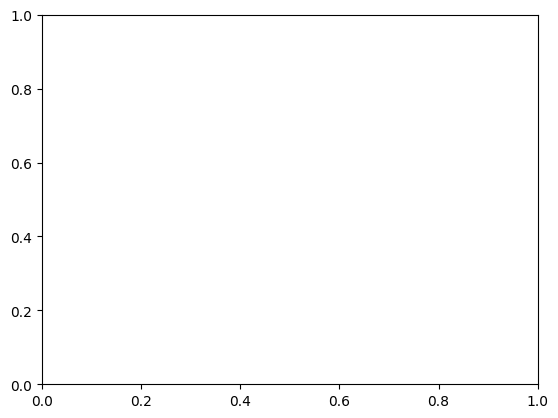

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1), recon_history, marker='o')
plt.xlabel('Epoch'); plt.ylabel('Reconstruction error'); plt.title('RBM CD-1 training')
plt.grid(True); plt.show()


Extracting the learned hidden representations of MNIST

In [ ]:
def get_hidden_repr(X_input, batch_size=256):
    # returns numpy array of shape (N, hidden_dim)
    ds = tf.data.Dataset.from_tensor_slices(X_input).batch(batch_size)
    parts = []
    for b in ds:
        ph = rbm.propup(b)   # tensor
        parts.append(ph.numpy())
    return np.vstack(parts)

N = 2000  # number of images to reduce for visualization
X_subset = X_bin[:N]
hidden_repr = get_hidden_repr(X_subset)   # shape (N, hidden_dim)
print("Hidden representation shape:", hidden_repr.shape)


Visualizing in 2D with PCA and t-SNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(hidden_repr)

plt.figure(figsize=(6,5))
plt.scatter(z_pca[:,0], z_pca[:,1], c=y_all[:N], cmap='tab10', s=6)
plt.title('PCA of RBM hidden representations')
plt.colorbar(ticks=range(10)); plt.show()

# t-SNE (use fewer points if slow)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', random_state=42)
z_tsne = tsne.fit_transform(hidden_repr)

plt.figure(figsize=(6,5))
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=y_all[:N], cmap='tab10', s=6)
plt.title('t-SNE of RBM hidden representations')
plt.colorbar(ticks=range(10)); plt.show()


Conclusion

After training, the RBM was able to reduce the MNIST images into smaller hidden features that still captured important information. The reconstruction error decreased as the model learned, showing that the RBM was improving over time. When the hidden features were visualized using PCA or t-SNE, the digits formed clear groups, meaning the RBM successfully learned meaningful patterns. Overall, this shows that an RBM is a useful method for simple dimensionality reduction and feature learning on image data.